In [1]:
## loading required libraries
import nltk
import math
import re
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# reading input files
def read_data(file_path):
    with open(file_path, 'r') as f:
        sents = []
        for line in f:
            sent = []
            sent.append('START1')
            sent.append('START2')
            tokens = nltk.word_tokenize(line.lower())
            for token in tokens:
                sent.append(token)
            sent.append('STOP')
            sents.append(sent)
        return sents

In [3]:
train_data = read_data('CSE517-HW1-Data-Full/brown.train.txt')
dev_data = read_data('CSE517-HW1-Data-Full/brown.dev.txt')
test_data = read_data('CSE517-HW1-Data-Full/brown.test.txt')

In [4]:
# extracting vocabulary given a dataset
def get_vocab(sents):
    vocab_dict = {}
    for sent in sents:
        for word in sent:
            if word not in vocab_dict.keys():
                vocab_dict[word] = 1
            else:
                vocab_dict[word] += 1
    return vocab_dict

In [5]:
def get_oov_count(vocab_ref, vocab):
    count = 0
    for word in vocab:
        if word not in vocab_ref.keys():
            count += 1
    return count

In [6]:
train_vocab = get_vocab(train_data)
dev_vocab = get_vocab(dev_data)
test_vocab = get_vocab(test_data)

In [7]:
print ("Training Vocab Size = " ,len(train_vocab.keys()))
print ("Dev Vocab Size = " ,len(dev_vocab.keys()))
print ("Test Vocab Size = " ,len(test_vocab.keys()))

Training Vocab Size =  43050
Dev Vocab Size =  15488
Test Vocab Size =  15215


In [8]:
print ("OOV words in dev set given training set = " , get_oov_count(train_vocab, dev_vocab))
print ("OOV words in test set given training set = " , get_oov_count(train_vocab, test_vocab))

OOV words in dev set given training set =  2425
OOV words in test set given training set =  2280


In [9]:
dev_train_mismatch = {}
for w, v in dev_vocab.items():
    if w not in train_vocab.keys():
        dev_train_mismatch[w] = v
        
print (sum(dev_train_mismatch.values()))
print (len(dev_train_mismatch.keys()))

2540
2425


In [10]:
train_vocabu = pd.DataFrame(list(train_vocab.items()), columns=['word', 'count'])
train_vocabu['count'].sum()

1074568

In [11]:
training_vocab_coverage = []
training_corpus_coverage = []
dev_vocab_coverage = []
dev_corpus_coverage = []

for n in range(1,16,1):
    train_unk_overall = train_vocabu.loc[train_vocabu['count'] <= n].sum(axis=0)['count']
    train_unk_vocab = train_vocabu.loc[train_vocabu['count'] <= n]['word'].tolist()
    training_vc = (1 - len(train_unk_vocab)/len(train_vocab.keys()))*100
    training_cc = (1 - train_unk_overall/sum(train_vocab.values()))*100
    
    training_vocab_coverage.append(training_vc)
    training_corpus_coverage.append(training_cc)
    print ("Training Vocab Coverage at", n, "=",  training_vc)
    print ("Training Corpus Coverage at", n,  "=", training_cc)
    
    dev_unk_overall = 0
    dev_unk_vocab = 0
    for k,v in dev_vocab.items():
        if k in train_unk_vocab:
            dev_unk_overall += v
            dev_unk_vocab += 1
            
    dev_vc = (1- (len(dev_train_mismatch.keys()) + dev_unk_vocab)/len(dev_vocab.keys()))*100
    dev_cc = (1- (sum(dev_train_mismatch.values()) + dev_unk_overall)/sum(dev_vocab.values()))*100
    dev_vocab_coverage.append(dev_vc)
    dev_corpus_coverage.append(dev_cc)
    print ("Dev Vocab Coverage at", n, "=", dev_vc)
    print ("Dev Corpus Coverage at", n, "=", dev_cc)
    print ("\n")

Training Vocab Coverage at 1 = 56.058072009291514
Training Corpus Coverage at 1 = 98.23957162320114
Dev Vocab Coverage at 1 = 75.21952479338843
Dev Corpus Coverage at 1 = 96.98616854832194


Training Vocab Coverage at 2 = 41.38908246225319
Training Corpus Coverage at 2 = 97.06421557314195
Dev Vocab Coverage at 2 = 68.04622933884296
Dev Corpus Coverage at 2 = 96.02024401530788


Training Vocab Coverage at 3 = 33.47038327526133
Training Corpus Coverage at 3 = 96.11248427274961
Dev Vocab Coverage at 3 = 62.17716942148761
Dev Corpus Coverage at 3 = 95.18506820235201


Training Vocab Coverage at 4 = 28.378629500580722
Training Corpus Coverage at 4 = 95.29652846539261
Dev Vocab Coverage at 4 = 57.444473140495866
Dev Corpus Coverage at 4 = 94.50047378047437


Training Vocab Coverage at 5 = 24.792102206736356
Training Corpus Coverage at 5 = 94.57810022260108
Dev Vocab Coverage at 5 = 53.279958677685954
Dev Corpus Coverage at 5 = 93.84966835366795


Training Vocab Coverage at 6 = 22.09059233449

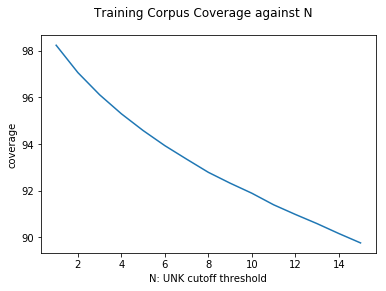

In [12]:
fig = plt.figure()
plt.plot(list(range(1,16)), training_corpus_coverage)
fig.suptitle('Training Corpus Coverage against N', fontsize=12)
plt.ylabel('coverage', fontsize=10)
plt.xlabel('N: UNK cutoff threshold', fontsize=10)
fig.savefig('training_cc.jpg')

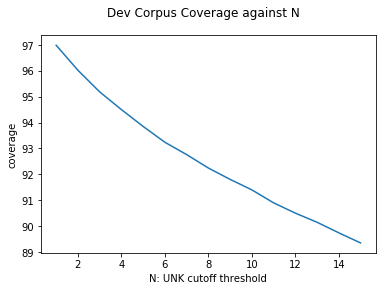

In [13]:
fig = plt.figure()
plt.plot(list(range(1,16)), dev_corpus_coverage)
fig.suptitle('Dev Corpus Coverage against N', fontsize=12)
plt.ylabel('coverage', fontsize=10)
plt.xlabel('N: UNK cutoff threshold', fontsize=10)
fig.savefig('dev_cc.jpg')

In [14]:
unk_set = train_vocabu.loc[train_vocabu['count'] <= 3]['word'].tolist()

In [15]:
def replace_rare_with_unk(data, unk_set):
    new_data = []
    for sent in data:
        new_sent = []
        for w in sent:
            if w not in unk_set:
                new_sent.append(w)
            else:
                new_sent.append('UNK')
        new_data.append(new_sent)
    return new_data

In [16]:
train_new = replace_rare_with_unk(train_data, unk_set)
train_vocab_new = get_vocab(train_new)
len(train_vocab_new.keys())

14410

In [17]:
with open('new_train_3.txt', 'w') as f:
    for sent in train_new:
        sen = ' '.join(sent)
        f.write("%s\n" % sen)

In [18]:
class unigram_LM():
    def __init__(self, data):
        self.corpus_size = 0
        self.unigrams = {}
        self.vocab_size = 0
        for sent in data:
            for i in range(len(sent)):
                if sent[i] not in self.unigrams.keys():
                    self.unigrams[sent[i]] = 1
                else:
                    self.unigrams[sent[i]] += 1
        self.vocab_size = len(self.unigrams.keys())
        self.corpus_size = sum(self.unigrams.values())
    
    def calc_unigram_prob(self, word):
        return (float(self.unigrams[word]) / float(self.corpus_size))
    
    def calc_ug_sent_prob(self, sent):
        log_sum_prob = 0.0
        for i in range(len(sent)):
            word_prob = self.calc_unigram_prob(sent[i])
            if sent[i] not in self.unigrams.keys():
                print ("word not found ", sent[i])
            log_sum_prob += math.log(word_prob, 2)
        return log_sum_prob
    
def calc_unigram_perplexity(lm, data):
    log_perplexity = 0
    M = 0
    for sent in data:
        M += len(sent)
        try:
            log_perplexity += lm.calc_ug_sent_prob(sent)
        except:
#             print (sent)
            log_perplexity += float('-inf')
    l = log_perplexity / M
    return math.pow(2, -1* l)

In [20]:
# lm = unigram_LM(train_new)
# prob = 0.0
# for token in lm.unigrams.keys():
#     prob += lm.calc_unigram_prob(token)
# print (prob)

1.0000000000001603


In [45]:
class bigram_LM(unigram_LM):
    def __init__(self, data):
        unigram_LM.__init__(self, data)
        self.bigrams = {}
        for sent in data:
            for i in range(len(sent)-1):
                if (sent[i], sent[i+1]) not in self.bigrams.keys():
                    self.bigrams[(sent[i], sent[i+1])] = 1
                else:
                    self.bigrams[(sent[i], sent[i+1])] += 1
                    
    def calc_bigram_prob(self, prev_word, word):
        prob_numerator = self.bigrams.get((prev_word, word), 0)
        if prob_numerator == 0:
            print ("word not found: ", (prev_word, word))
        prob_denominator = self.unigrams.get(prev_word, 0)
        if prob_numerator == 0 or prob_denominator == 0:
            return 0
        else:
            return (float(prob_numerator) / float(prob_denominator))
            
    def calc_bg_sent_prob(self, sent):
        log_sum_prob = 0
        for i in range(len(sent)-1):
            log_sum_prob += math.log(self.calc_bigram_prob(sent[i], sent[i+1]), 2)
        return log_sum_prob
        
def calc_bigram_perplexity(lm, data):
    log_perplexity = 0.0
    M = 0
    for sent in data:
        M += len(sent)
        try:
            log_perplexity += lm.calc_bg_sent_prob(sent)
        except:
#             print (sent)
            log_perplexity += float('-inf')
    l = log_perplexity / M
    return math.pow(2, -1 * l)

In [47]:
class trigram_LM(bigram_LM):
    def __init__(self, data):
        bigram_LM.__init__(self, data)
        self.trigrams = {}
        for sent in data:
            for i in range(len(sent)-2):
                if (sent[i], sent[i+1], sent[i+2]) not in self.trigrams.keys():
                    self.trigrams[(sent[i], sent[i+1], sent[i+2])] = 1
                else:
                    self.trigrams[(sent[i], sent[i+1], sent[i+2])] += 1
            
    def calc_trigram_prob(self, prev_prev_word, prev_word, word):
        prob_numerator = self.trigrams.get((prev_prev_word, prev_word, word), 0)
        if prob_numerator == 0:
            print ("word not found: ", (prev_word, prev_prev_word, word))
        prob_denominator = self.bigrams.get((prev_prev_word, prev_word), 0)
        if prob_numerator == 0 or prob_denominator == 0:
            return 0
        else:
            return (float(prob_numerator) / float(prob_denominator))
            
    def calc_tg_sent_prob(self, sent):
        log_sum_prob = 0.0
        for i in range(len(sent)-2):
            log_sum_prob += math.log(self.calc_trigram_prob(sent[i], sent[i+1], sent[i+2]), 2)
        return log_sum_prob

    
def calc_trigram_perplexity(lm, data):
    log_perplexity = 0.0
    M = 0
    for sent in data:
        M += len(sent)
        try:
            log_perplexity += lm.calc_tg_sent_prob(sent)
        except:
#             print (sent)
            log_perplexity += float('-inf')
    l = log_perplexity / M
    return math.pow(2, -1 * l)

In [24]:
lm = unigram_LM(train_new)
perp = calc_unigram_perplexity(lm, train_new)
print (perp)

491.8703842489886


In [25]:
lm = bigram_LM(train_new)
perp = calc_bigram_perplexity(lm, train_new)
print (perp)

47.38277731094119


In [26]:
lm = trigram_LM(train_new)
perp = calc_trigram_perplexity(lm, train_new)
print (perp)

6.927805056156131


In [ ]:
def preprocess_data(data, vocab):
    new_data = []
    for sent in data:
        new_sent = []
        for w in sent:
            if w in vocab:
                new_sent.append(w)
            else:
                new_sent.append('UNK')
        new_data.append(new_sent)
    return new_data

dev_new = preprocess_data(dev_data, train_vocab_new)
test_new = preprocess_data(test_data, train_vocab_new)

In [31]:
lm = unigram_LM(train_new)
perp = calc_unigram_perplexity(lm, dev_new)
print (perp)

459.5108174392344


In [40]:
lm = unigram_LM(train_new)
perp = calc_unigram_perplexity(lm, test_new)
print (perp)

464.49323667709393


In [48]:
lm = bigram_LM(train_new)
perp = calc_bigram_perplexity(lm, dev_new)
print (perp)

word not found:  ("'s", 'automobile')
word not found:  ('jury', 'took')
word not found:  ('START2', 'regarding')
word not found:  ('START2', 'hartsfield')
word not found:  ('START2', 'caldwell')
word not found:  ('fund', 'STOP')
word not found:  ('veteran', 'jackson')
word not found:  ('committee', 'the')
word not found:  ('also', 'complained')
word not found:  ('more', "'")
word not found:  ('house', 'passed')
word not found:  ('third', 'amended')
word not found:  ('without', 'dissent')
word not found:  ('two', 'tax')
word not found:  ('recommendations', 'by')
word not found:  ('START2', 'natural')
word not found:  ('proposal', 'would')
word not found:  ('rep.', 'james')
word not found:  ('also', 'would')
word not found:  ('the', '150')
word not found:  ('studied', 'at')
word not found:  ('solve', 'problem')
word not found:  ('extension', 'STOP')
word not found:  ('causes', 'and')
word not found:  ('charles', 'bellows')
word not found:  ('if', 'true')
word not found:  ('president', 's

word not found:  ('the', 'choices')
word not found:  ('governor', 'nelson')
word not found:  ('speaking', 'recently')
word not found:  ('he', 'asserted')
word not found:  ('perfectly', 'conceivable')
word not found:  ('testing', 'would')
word not found:  ('john', '23')
word not found:  ('dramatic', 'mark')
word not found:  ('budget', 'deficit')
word not found:  ('our', 'complaint')
word not found:  ('START2', 'ethics')
word not found:  ('START2', 'sessions')
word not found:  ('speakers', 'declared')
word not found:  ('aid', 'demanded')
word not found:  ('interpreter', ',')
word not found:  ('ever', 'there')
word not found:  ('it', 'adds')
word not found:  ('physical', 'survival')
word not found:  ('army', 'which')
word not found:  ('most', 'definitely')
word not found:  ('START2', 'china')
word not found:  ('on', 'america')
word not found:  ('crisis', 'erupted')
word not found:  ('measure', 'was')
word not found:  ('who', 'rape')
word not found:  ('what', 'explains')
word not found:  (

word not found:  ('street', 'i')
word not found:  ('do', 'start')
word not found:  ('the', 'barbecue')
word not found:  ('drink', 'tray')
word not found:  ('without', 'fancy')
word not found:  ('or', 'buy')
word not found:  ('travel', 'over')
word not found:  ('make', 'buns')
word not found:  ('popular', 'opinion')
word not found:  ('START2', 'spear')
word not found:  ('START2', 'frankfurter')
word not found:  ('START2', 'twist')
word not found:  ('START2', 'serves')
word not found:  ('bend', 'without')
word not found:  ('if', 'clay')
word not found:  ('no', 'bisque')
word not found:  ('START2', 'round')
word not found:  ('if', 'design')
word not found:  ('place', 'jar')
word not found:  ('with', 'touches')
word not found:  ('score', 'outside')
word not found:  ('make', 'lid')
word not found:  ('place', 'work')
word not found:  ('to', 'insert')
word not found:  ('place', 'sleeve')
word not found:  ('START2', 'weaving')
word not found:  ('UNK', 'seams')
word not found:  ('START2', 'stra

word not found:  ('buddha', 'and')
word not found:  ('northeast', ',')
word not found:  ('we', 'flew')
word not found:  ('UNK', 'illustrations')
word not found:  ('mountainous', 'half')
word not found:  ('enjoyed', 'our')
word not found:  ('more', 'bouncing')
word not found:  ('we', 'ask')
word not found:  ('fighting', 'and')
word not found:  ('good', 'protestant')
word not found:  ('maintaining', 'their')
word not found:  ('were', 'hostile')
word not found:  ('jewish', 'family')
word not found:  ('girl', 'remarked')
word not found:  ('teen-agers', ',')
word not found:  ('UNK', 'territory')
word not found:  ('young', 'women')
word not found:  ('other', 'skin')
word not found:  ('``', 'female')
word not found:  ('family', 'bound')
word not found:  ('cured', 'or')
word not found:  ('were', 'known')
word not found:  ('while', 'nowadays')
word not found:  ('victim', 'could')
word not found:  ('used', 'also')
word not found:  ('START2', 'shingles')
word not found:  ('six', 'treatments')
wor

word not found:  ('for', 'irony')
word not found:  ('speaks', 'false')
word not found:  ('sailing', 'vessel')
word not found:  ('in', 'recollection')
word not found:  ('his', 'canvases')
word not found:  ('continuing', 'as')
word not found:  ('political', 'man')
word not found:  ('studio', 'on')
word not found:  ('haste', 'he')
word not found:  ('march', 'during')
word not found:  ('his', 'capture')
word not found:  ('prisoners', 'would')
word not found:  ('david', 'held')
word not found:  ('prison', 'he')
word not found:  ('beings', 'banished')
word not found:  ('hats', 'to')
word not found:  ('been', 'explicit')
word not found:  ('region', 'a')
word not found:  ('literature', 'at')
word not found:  ('characters', 'had')
word not found:  ('UNK', 'simms')
word not found:  ('START2', 'simms')
word not found:  ('tensions', 'thus')
word not found:  ('ago', 'julian')
word not found:  ('about', 'tobacco')
word not found:  ('sure', 'devotion')
word not found:  ('not', 'angry')
word not found

word not found:  ('the', 'rayburn')
word not found:  ('although', 'sam')
word not found:  ('exceptions', 'travelers')
word not found:  ('practices', 'STOP')
word not found:  ('few', 'records')
word not found:  ('indicate', 'loose')
word not found:  ('was', 'financed')
word not found:  ('management', 'considerable')
word not found:  ('maintenance', 'rotary')
word not found:  ('present', 'management')
word not found:  ('pool', 'personnel')
word not found:  ('vehicles', 'averaged')
word not found:  ('invariably', 'lower')
word not found:  ('all', 'matters')
word not found:  ('almost', 'solely')
word not found:  ('policies', 'have')
word not found:  ('island', 'property')
word not found:  ('both', 'boats')
word not found:  ('where', 'every')
word not found:  ('recent', 'example')
word not found:  ('START2', 'assessment')
word not found:  ('fair', 'valuation')
word not found:  ('municipal', 'governments')
word not found:  ('UNK', 'exactly')
word not found:  ('was', 'fairly')
word not found:

word not found:  ('the', 'interpretations')
word not found:  ('final', 'sample')
word not found:  ('appeared', 'relatively')
word not found:  ('raised', 'whether')
word not found:  ('START2', 'criterion')
word not found:  ('school', 'progress')
word not found:  ('START2', 'tables')
word not found:  ('theory', 'proposed')
word not found:  ('child', 'suffered')
word not found:  ('point', 'stress')
word not found:  ('examples', 'STOP')
word not found:  ('START2', 'interviewing')
word not found:  ('one', 'handled')
word not found:  ('all', 'applicants')
word not found:  ('personnel', 'went')
word not found:  ('of', 'typical')
word not found:  ('these', 'errors')
word not found:  ('over-all', 'estimate')
word not found:  ('distinctions', 'between')
word not found:  ('hebephrenic', 'woman')
word not found:  ('meant', ';')
word not found:  ('its', 'continuing')
word not found:  ('particularly', 'hard')
word not found:  ('some', 'bit')
word not found:  ('these', 'accumulated')
word not found: 

word not found:  ('dirty', 'wooden')
word not found:  ('began', 'invariably')
word not found:  ('devoted', 'soul')
word not found:  ('pastor', 'like')
word not found:  ('city', 'itself')
word not found:  ('wilson', 'inquired')
word not found:  ('leading', 'members')
word not found:  ('behind', 'were')
word not found:  ('told', 'wilson')
word not found:  ('was', 'next')
word not found:  ('--', 'putting')
word not found:  ('wages', 'involved')
word not found:  ('the', 'inmates')
word not found:  ('been', 'anywhere')
word not found:  ('before', 'payne')
word not found:  ('still', 'good')
word not found:  ('kill', ',')
word not found:  ('saw', 'only')
word not found:  ('men', 'pulled')
word not found:  ('made', 'things')
word not found:  ('still', 'yelling')
word not found:  ('walked', 'it')
word not found:  ('to', 'cap')
word not found:  ('done', 'as')
word not found:  ('any', 'worries')
word not found:  ('collect', 'her')
word not found:  ('had', 'stunned')
word not found:  ('sitting', '

word not found:  ('was', 'framed')
word not found:  ('be', 'mahzeer')
word not found:  (',', 'seated')
word not found:  ('would', 'direct')
word not found:  ('was', 'generously')
word not found:  ('peered', 'in')
word not found:  ('inner', 'door')
word not found:  ('was', 'none')
word not found:  ('as', 'killpath')
word not found:  ('killpath', 'pulled')
word not found:  ('stretching', 'his')
word not found:  ('just', 'guessing')
word not found:  ('but', 'stupidity')
word not found:  ('stretched', 'a')
word not found:  ('``', 'patrolman')
word not found:  ('sergeant', 'is')
word not found:  ('about', 'killpath')
word not found:  ('through', 'casey')
word not found:  ('secret', '?')
word not found:  ('casey', 'kept')
word not found:  ('burton', 'at')
word not found:  ('glance', 'focused')
word not found:  ('thoughts', 'confused')
word not found:  ('jack', ':')
word not found:  ('casey', 'heard')
word not found:  ('still', 'took')
word not found:  ('a', 'bang')
word not found:  ('casey',

word not found:  ('holy', 'mary')
word not found:  ('bit', 'confused')
word not found:  ('was', 'content')
word not found:  ('between', 'starvation')
word not found:  ('meadow', "''")
word not found:  ('signal', '?')
word not found:  ('fresh', 'on')
word not found:  ('faint', 'creaking')
word not found:  ('convinced', 'they')
word not found:  ('UNK', 'marine')
word not found:  ('no', 'head')
word not found:  ('of', 'cigarettes')
word not found:  ('no', 'saying')
word not found:  ('bad', 'the')
word not found:  ('marine', 'reached')
word not found:  ('lacked', 'even')
word not found:  ('he', 'sniffed')
word not found:  ('weep', 'and')
word not found:  ('soon', 'die')
word not found:  ('rifle', 'off')
word not found:  ('he', 'performed')
word not found:  ('sun', 'he')
word not found:  ('only', 'blue')
word not found:  ('since', 'when')
word not found:  ('alert', 'now')
word not found:  ('fist', 'swept')
word not found:  ('of', 'tilghman')
word not found:  ('back', 'tomorrow')
word not fo

word not found:  ('order', 'then')
word not found:  ('rather', 'unpleasant')
word not found:  ('probably', 'very')
word not found:  ('leads', 'the')
word not found:  ('thought', 'by')
word not found:  ('the', 'collective')
word not found:  ('a', 'paso')
word not found:  ('as', 'familiar')
word not found:  ('foregoing', ',')
word not found:  (',', 'ordinarily')
word not found:  ('own', 'amount')
word not found:  ('wooden', 'sculpture')
word not found:  ('we', 'discovered')
word not found:  ('had', 'aged')
word not found:  ('himself', 'thirteen')
inf


In [49]:
lm = bigram_LM(train_new)
perp = calc_bigram_perplexity(lm, test_new)
print (perp)

word not found:  ('jury', 'further')
word not found:  ('relative', 'handful')
word not found:  ('not', 'elaborate')
word not found:  ('jury', 'recommended')
word not found:  ('william', 'berry')
word not found:  ('START2', 'attorneys')
word not found:  ('vandiver', 'likely')
word not found:  ('county', 'rep.')
word not found:  ('was', 'research')
word not found:  ("n't", 'smell')
word not found:  ('lawyer', 'representing')
word not found:  ('rep.', 'charles')
word not found:  ("'m", 'willing')
word not found:  ('rep.', 'berry')
word not found:  ('committee', 'which')
word not found:  ('adverse', 'vote')
word not found:  ('roberts', 'of')
word not found:  ('--', 'paradise')
word not found:  ("'s", 'defenders')
word not found:  ('rep.', 'henry')
word not found:  ('yet', 'who')
word not found:  ('monthly', 'cost')
word not found:  ('defendants', 'strongly')
word not found:  ('24', 'STOP')
word not found:  ('START2', 'contempt')
word not found:  ('similar', 'payroll')
word not found:  ('ho

word not found:  ('START2', 'pass')
word not found:  ('making', 'recently')
word not found:  ('but', 'except')
word not found:  ('of', 'kings')
word not found:  ('york', 'debut')
word not found:  ('his', 'pianist')
word not found:  ('title', 'refers')
word not found:  ('high', 'command')
word not found:  ('delicate', 'diplomatic')
word not found:  ('START2', 'hospitals')
word not found:  ('START2', 'brooding')
word not found:  ('by', 'background')
word not found:  ('other', 'capable')
word not found:  ('likely', 'the')
word not found:  ('dances', 'and')
word not found:  ('and', 'eleanor')
word not found:  ('troubles', 'begin')
word not found:  ('is', 'awfully')
word not found:  ('it', 'strikes')
word not found:  ('as', 'exciting')
word not found:  ('all', 'ears')
word not found:  ('and', 'paul')
word not found:  ('of', 'charm')
word not found:  ('START2', 'jen')
word not found:  ('times', 'recently')
word not found:  ('daughter', 'on')
word not found:  ('increasing', 'lack')
word not f

word not found:  ('realtors', 'UNK')
word not found:  ('of', 'minority')
word not found:  (')', 'realtors')
word not found:  ('social', 'scientist')
word not found:  ('opportunities', 'UNK')
word not found:  ('START2', 'racial')
word not found:  ('power', 'with')
word not found:  ('atoms', 'STOP')
word not found:  ('turnpike', 'with')
word not found:  ('we', 'cover')
word not found:  ('us', 'focus')
word not found:  ('this', 'atomic')
word not found:  ('many', 'scientists')
word not found:  (',', 'counterpoint')
word not found:  ('this', 'music')
word not found:  ('one', 'boat')
word not found:  ('fine', 'trip')
word not found:  ('temptation', 'is')
word not found:  ('prominent', 'must')
word not found:  ('conscience', 'was')
word not found:  ('after', '1815')
word not found:  ('chinese', 'emperor')
word not found:  ('he', 'regulated')
word not found:  ('temple', ';')
word not found:  ('common', 'belief')
word not found:  ('empirical', 'determination')
word not found:  ('magical', 'sys

word not found:  ('(', 'hymen')
word not found:  ('often', 'suggested')
word not found:  ('sexual', 'stimulation')
word not found:  ('such', 'talk')
word not found:  ('keeping', 'alert')
word not found:  ('frequent', 'need')
word not found:  ('equally', 'ardent')
word not found:  ('to', 'bump')
word not found:  ('been', 'dominant')
word not found:  ('these', 'roles')
word not found:  ('she', 'begins')
word not found:  ('extreme', 'case')
word not found:  ('every', 'money')
word not found:  ('sex', 'urge')
word not found:  ('man', 'once')
word not found:  ('with', 'darkness')
word not found:  ('START2', 'marriage')
word not found:  ('often', 'she')
word not found:  ('make', 'sudden')
word not found:  ('wealthy', 'foreign')
word not found:  ('our', 'information')
word not found:  ('denied', 'this')
word not found:  ('``', 'diane')
word not found:  ('quickly', 'moved')
word not found:  ('most', 'gamblers')
word not found:  ('ever', 'learned')
word not found:  (',', 'diane')
word not found

word not found:  ('two', 'thieves')
word not found:  ('play', 'she')
word not found:  ('irish', 'bus')
word not found:  ('for', 'distress')
word not found:  ('is', 'screaming')
word not found:  ('not', 'sex')
word not found:  ('one', 'outlet')
word not found:  ('mind', 'has')
word not found:  ('girl', 'describes')
word not found:  ('START2', 'boredom')
word not found:  ('are', 'driven')
word not found:  ('marriages', 'do')
word not found:  ('are', 'sexual')
word not found:  ('from', 'maturity')
word not found:  ('that', 'bloomed')
word not found:  ('more', 'potent')
word not found:  ('thus', 'shielded')
word not found:  ('the', 'specifically')
word not found:  ('strange', 'person')
word not found:  (',', 'piepsam')
word not found:  ('passion', 'brings')
word not found:  ('but', 'several')
word not found:  ('between', 'spring')
word not found:  ('as', 'piepsam')
word not found:  ('the', 'ambulance')
word not found:  ('wardrobe', 'at')
word not found:  ('classical', 'structures')
word no

word not found:  ('stands', 'is')
word not found:  ('somehow', 'preserved')
word not found:  ('so', 'apparently')
word not found:  ('be', 'farther')
word not found:  ('narrator', 'is')
word not found:  ('their', 'possible')
word not found:  ("''", 'writes')
word not found:  ("''", 'finally')
word not found:  ('popular', 'european')
word not found:  ('years', 'my')
word not found:  ('states', 'might')
word not found:  ('besides', 'its')
word not found:  ('these', 'hopes')
word not found:  ('compelling', 'is')
word not found:  ('rexroth', 'is')
word not found:  ('francisco', 'he')
word not found:  ('beauty', 'as')
word not found:  ('must', 'rely')
word not found:  ('since', '1945')
word not found:  ('coast', 'schools')
word not found:  ('the', 'accent')
word not found:  ('authority', 'either')
word not found:  ('in', 'patchen')
word not found:  ('perhaps', 'tracing')
word not found:  ('miller', 'characterized')
word not found:  ('revolutionary', 'anger')
word not found:  ('one', 'manner'

word not found:  ('must', 'formulate')
word not found:  ('economic', 'sphere')
word not found:  ('START2', 'convinced')
word not found:  ('condition', 'affects')
word not found:  ('not', 'greatly')
word not found:  ('higher', 'religious')
word not found:  ('oldest', ',')
word not found:  ('common', 'codes')
word not found:  ('usually', 'exercises')
word not found:  ('among', 'primitive')
word not found:  ('(', 'during')
word not found:  ('the', 'b.')
word not found:  ('denial', 'in')
word not found:  ('these', 'needs')
word not found:  ('obviously', 'nothing')
word not found:  ('some', 'programs')
word not found:  ('treatment', 'resources')
word not found:  ('of', 'crises')
word not found:  ('evaluation', 'UNK')
word not found:  ('some', 'indication')
word not found:  ('stable', 'UNK')
word not found:  ('each', 'family')
word not found:  ('their', 'intermediate')
word not found:  ('considers', 'six')
word not found:  ('START2', 'urbanization')
word not found:  ('setting', 'social')
wor

word not found:  ('device', 'resolution')
word not found:  (',', 'elementary')
word not found:  ('whatever', 'transformation')
word not found:  ('important', 'this')
word not found:  ('is', 'vastly')
word not found:  ('program', 'would')
word not found:  ('functional', 'equation')
word not found:  ('feed', 'to')
word not found:  ('here', 'p')
word not found:  ('hence', 'p')
word not found:  ('for', 'chemical')
word not found:  ('word', 'distance')
word not found:  ('thus', 'if')
word not found:  ('the', 'voltage')
word not found:  ('acceleration', 'present')
word not found:  ('the', 'amplifier')
word not found:  ('the', 'amplifier')
word not found:  ('platform', 'returns')
word not found:  ('leveling', 'requires')
word not found:  ('a', 'precision')
word not found:  ('accuracy', 'by')
word not found:  ('instrument', 'provides')
word not found:  ('gyro', 'vectors')
word not found:  ('spinning', 'at')
word not found:  ('rachel', 'was')
word not found:  ('anxiously', 'watch')
word not fou

word not found:  ('finally', 'through')
word not found:  ('UNK', 'tentatively')
word not found:  ('money', "'s")
word not found:  ("'s", 'horses')
word not found:  ('son', 'watched')
word not found:  ('brows', 'the')
word not found:  ('grew', 'high')
word not found:  ('mr.', 'ferguson')
word not found:  ('a', 'pounding')
word not found:  ('little', 'accidents')
word not found:  ('planning', 'his')
word not found:  ('familiar', 'scenes')
word not found:  ('except', 'home')
word not found:  ('START2', 'cooper')
word not found:  ('idea', 'drifted')
word not found:  ('START2', 'good-bye')
word not found:  ("'re", 'gone')
word not found:  ('another', 'bite')
word not found:  ('never', 'owned')
word not found:  ('sketch', 'pad')
word not found:  ('dumont', 'for')
word not found:  ('find', 'what')
word not found:  ('(', 'anyone')
word not found:  (':', 'sorry')
word not found:  ('no', 'oil')
word not found:  ('START2', 'pass')
word not found:  (',', 'gone')
word not found:  ('motive', '--')
w

word not found:  ('nicolas', ':')
word not found:  ('just', 'spent')
word not found:  ('her', 'reward')
word not found:  ('he', 'blew')
word not found:  ('muscles', 'for')
word not found:  ('was', 'grace')
word not found:  ('windows', 'onto')
word not found:  ('maids', 'UNK')
word not found:  ('she', 'whispered')
word not found:  ('prime', 'extended')
word not found:  ('he', 'commanded')
word not found:  ('he', 'cleared')
word not found:  ('idea', 'before')
word not found:  ('he', 'darkened')
word not found:  ('wife', 'did')
word not found:  ('tree', 'ride')
word not found:  ('the', 'slashed')
word not found:  ('rail', 'and')
word not found:  ('was', 'quivering')
word not found:  ('stern', 'was')
word not found:  ('we', 'peered')
word not found:  ('been', 'speaking')
word not found:  ('very', 'religion')
word not found:  ('is', 'eromonga')
word not found:  ('fine', 'example')
word not found:  ('was', 'filling')
word not found:  ('were', 'shattered')
word not found:  ('took', 'thirty')


word not found:  ('chosen', 'UNK')
word not found:  (',', 'fran')
word not found:  ('UNK', 'colonial')
word not found:  ('only', 'enthusiasm')
word not found:  ('always', 'let')
word not found:  ('not', 'blanche')
word not found:  ('boys', 'acknowledged')
word not found:  ('light', 'cigarettes')
word not found:  ('in', 'paradise')
word not found:  ('the', 'litigation')
word not found:  ('my', 'plea')
word not found:  ('about', 'religion')
word not found:  ('to', 'letch')
word not found:  ('only', 'george')
word not found:  ('rare', 'fit')
word not found:  ('great', 'english')
word not found:  ('day', 'would')
word not found:  ('these', 'walks')
word not found:  ('he', 'formerly')
word not found:  ('his', 'misfortune')
word not found:  ('distant', 'farm')
word not found:  ('get', 'everything')
word not found:  ('unload', 'the')
word not found:  ('followed', 'mr.')
word not found:  ('i', 'wait')
word not found:  ('ambiguity', 'STOP')
word not found:  ('as', 'misses')
word not found:  ('a

In [50]:
lm = trigram_LM(train_new)
perp = calc_trigram_perplexity(lm, dev_new)
print (perp)

word not found:  ('of', 'implementation', 'georgia')
word not found:  ('jury', 'grand', 'took')
word not found:  ('START2', 'START1', 'regarding')
word not found:  ('START2', 'START1', 'hartsfield')
word not found:  ('START2', 'START1', 'caldwell')
word not found:  ('a', 'START2', 'revolving')
word not found:  ('veteran', 'a', 'jackson')
word not found:  ('committee', 'the', 'the')
word not found:  ('also', 'he', 'complained')
word not found:  ("'re", 'we', 'getting')
word not found:  ('house', 'the', 'passed')
word not found:  ('third', 'the', 'amended')
word not found:  ('without', 'START2', 'dissent')
word not found:  ('two', 'START2', 'tax')
word not found:  ('of', 'series', 'recommendations')
word not found:  ('START2', 'START1', 'natural')
word not found:  ('proposal', 'the', 'would')
word not found:  ('rep.', 'START2', 'james')
word not found:  ('also', 'UNK', 'would')
word not found:  ('the', 'of', '150')
word not found:  (',', 'addition', 'dr.')
word not found:  ('``', 'START2

word not found:  ('having', 'START2', 'led')
word not found:  ('why', 'START2', 'trust')
word not found:  ('had', 'START2', 'it')
word not found:  ('to', 'wish', 'advocate')
word not found:  ('matter', 'the', 'may')
word not found:  ('does', 'START2', 'each')
word not found:  (',', 'unfortunately', 'those')
word not found:  ('are', 'they', 'working')
word not found:  (',', 'feels', 'therefore')
word not found:  ('if', 'but', 'his')
word not found:  ('another', 'START2', 'piece')
word not found:  ('for', 'materials', 'compromise')
word not found:  ('of', 'removal', 'stalin')
word not found:  ('in', 'and', 'england')
word not found:  ('can', 'he', 'hardly')
word not found:  ('if', 'START2', 'nikita')
word not found:  ('of', 'appointment', 'u')
word not found:  ('UNK', 'START2', 'slim')
word not found:  ('UNK', 'the', 'maintaining')
word not found:  ("'s", 'khrushchev', 'demand')
word not found:  ('is', 'u.n.', 'still')
word not found:  ('where', 'areas', 'political')
word not found:  ('a

word not found:  ('START2', 'START1', 'tend')
word not found:  ('file', 'START2', 'to')
word not found:  ('equation', 'the', 'is')
word not found:  ('they', 'START2', 'indicate')
word not found:  (',', 'example', 'for')
word not found:  ('numbers', 'START2', 'separated')
word not found:  ('is', 'this', 'with')
word not found:  ('number', 'a', 'without')
word not found:  ('START2', 'START1', 'multiplying')
word not found:  ('in', 'dimensions', 'inches')
word not found:  ('the', 'UNK', 'chamber')
word not found:  ('such', 'START2', 'liquids')
word not found:  ('the', ',', 'displacement')
word not found:  ('cylinder', 'the', 'opening')
word not found:  ('UNK', 'UNK', 'mile')
word not found:  ('is', 'she', 'owned')
word not found:  ('other', 'START2', 'good')
word not found:  (',', ')', 'caper')
word not found:  ('but', 'START2', 'up')
word not found:  ('is', 'time', 'around')
word not found:  ('is', ')', 'improving')
word not found:  ('date', 'to', 'she')
word not found:  ('hickory', 'STA

word not found:  ('the', 'was', 'bitter')
word not found:  ('hands', 'START2', 'on')
word not found:  ('was', 'it', 'being')
word not found:  ('having', 'START2', 'achieved')
word not found:  ('START2', 'START1', 'selkirk')
word not found:  ('years', 'many', 'the')
word not found:  ('in', 'when', 'UNK')
word not found:  ('were', 'they', 'held')
word not found:  ('trip', 'the', 'selkirk')
word not found:  ('thereafter', 'START2', 'seed')
word not found:  ('leaving', 'after', 'fort')
word not found:  ('in', 'START2', 'april')
word not found:  ('by', 'START2', 'fall')
word not found:  ('UNK', ',', 'red')
word not found:  ('the', 'below', 'fort')
word not found:  ('third', 'a', 'wrote')
word not found:  ('and', 'UNK', 'refined')
word not found:  ('START2', 'START1', 'humor')
word not found:  ('william', 'START2', 'r.')
word not found:  ('of', 'men', 'more')
word not found:  ('i', 'START2', 'eat')
word not found:  ('letters', 'the', 'which')
word not found:  ('near', 'UNK', 'petersburg')
wo

word not found:  ('the', 'START2', 'clause')
word not found:  ('england', 'new', 'conscience')
word not found:  ('was', 'he', 'referring')
word not found:  ('UNK', 'professor', 'book')
word not found:  ('tells', 'he', 'stories')
word not found:  ('his', 'of', 'return')
word not found:  ('the', 'START2', 'supreme')
word not found:  ('he', ',', 'answers')
word not found:  ("'s", 'man', 'true')
word not found:  (',', 'however', 'find')
word not found:  ('his', 'START2', 'next')
word not found:  (',', 'however', 'settle')
word not found:  ('the', 'on', 'fatal')
word not found:  ('men', 'charles', 'consists')
word not found:  ('comes', 'this', 'out')
word not found:  ('different', 'is', 'with')
word not found:  ('are', 'these', 'suggestive')
word not found:  ('a', 'is', 'superb')
word not found:  ('the', 'today', 'private')
word not found:  ('not', 'does', 'work')
word not found:  ('this', 'is', 'curious')
word not found:  ('did', 'only', 'the')
word not found:  ('the', 'on', 'fictional')
w

word not found:  ('they', 'START2', 'react')
word not found:  ('adams', 'START2', 'firmly')
word not found:  ('a', 'as', 'practicing')
word not found:  ('the', 'UNK', 'impact')
word not found:  ('the', 'if', 'historian')
word not found:  ('was', 'it', 'history')
word not found:  ('no', 'START2', 'page')
word not found:  ('j.', 'START2', 't.')
word not found:  ('must', 'he', 'regard')
word not found:  ('yet', 'not', 'undertaken')
word not found:  ('me', 'to', 'about')
word not found:  ('as', 'felt', 'i')
word not found:  ('never', 'could', 'forget')
word not found:  (',', 'later', 'rising')
word not found:  ('UNK', 'their', 'generalizations')
word not found:  ('she', 'and', 'withdrew')
word not found:  ('UNK', 'of', 'mind')
word not found:  ('a', 'after', 'dinner')
word not found:  ('in', 'START2', 'london')
word not found:  ('newspapers', 'the', 'he')
word not found:  ('a', 'was', 'dinner')
word not found:  ('at', ',', 'dawn')
word not found:  ('blackman', 'START2', 'said')
word not fo

word not found:  (',', 'accordingly', 'girls')
word not found:  ('UNK', 'if', 'fusion')
word not found:  ('thus', 'START2', 'early')
word not found:  ('of', 'absence', 'additions')
word not found:  ('1958', ',', ';')
word not found:  ('the', 'that', 'plasma')
word not found:  ('to', 'appear', 'affect')
word not found:  ('with', 'START2', 'lower')
word not found:  ('the', 'START2', 'hormone')
word not found:  ('first', 'the', 'attempts')
word not found:  ('developments', 'START2', 'up')
word not found:  ('two', 'START2', 'problems')
word not found:  (',', 'part', 'this')
word not found:  ('START2', 'START1', 'muscle')
word not found:  ('additional', 'START2', 'findings')
word not found:  ('UNK', 'START2', 'revealed')
word not found:  ('of', 'spite', 'normal')
word not found:  ('repeated', 'START2', 'attempts')
word not found:  ('these', 'START2', 'reactions')
word not found:  ('extensive', 'START2', 'UNK')
word not found:  ('heart', 'the', 'weighed')
word not found:  ('UNK', 'left', 'wa

word not found:  ('a', 'yet', 'fresh')
word not found:  ('seems', 'UNK', 'nearly')
word not found:  ('his', 'of', 'verse')
word not found:  ('the', 'START2', 'germanic')
word not found:  ('that', 'say', 'since')
word not found:  ('UNK', 'greatest', 'of')
word not found:  ('any', 'START2', 'example')
word not found:  ('epic', 'the', 'language')
word not found:  ('START2', 'START1', 'beowulf')
word not found:  ('they', 'yet', 'are')
word not found:  ('other', 'START2', 'theories')
word not found:  ('the', 'START2', 'account')
word not found:  ('UNK', 'the', 'used')
word not found:  ('the', 'START2', 'iliad')
word not found:  ('such', 'START2', 'associations')
word not found:  ("'", 'UNK', 'iron')
word not found:  ('UNK', 'that', 'pip')
word not found:  ('the', 'START2', 'respectability')
word not found:  ('illustrations', 'START2', 'of')
word not found:  ('initial', 'the', 'availability')
word not found:  ('a', 'of', 'symbolic')
word not found:  ('pass', 'assignment', 'of')
word not foun

word not found:  ('the', ',', 'flowers')
word not found:  (',', 'sighing', 'he')
word not found:  ('the', 'START2', 'china')
word not found:  ('what', '``', 'possessed')
word not found:  ('winston', 'START2', 'laid')
word not found:  ('only', 'had', 'agreed')
word not found:  ('what', 'me', 'to')
word not found:  ('christmas', 'on', 'night')
word not found:  ('had', 'she', 'asked')
word not found:  ('had', 'he', 'stood')
word not found:  ('these', 'START2', 'letters')
word not found:  ('many', 'for', 'nights')
word not found:  ('wearing', 'was', 'her')
word not found:  ('look', 'her', 'sweet')
word not found:  ('i', 'START2', 'forced')
word not found:  ('great', 'a', 'sense')
word not found:  ('looked', 'i', 'over')
word not found:  ('looked', 'i', 'for')
word not found:  ('i', 'that', 'lived')
word not found:  ("'ve", 'i', 'worked')
word not found:  ('not', "'ve", 'seemed')
word not found:  ('a', 'not', 'joke')
word not found:  ('eyes', 'her', 'flashed')
word not found:  ('you', 'tell

word not found:  ('rifle', 'the', 'around')
word not found:  ('mike', 'START2', 'took')
word not found:  ('he', 'START2', 'protested')
word not found:  ('dammit', '``', "''")
word not found:  ('``', 'START2', 'favor')
word not found:  ('might', 'you', 'need')
word not found:  ('way', 'his', 'at')
word not found:  ('his', 'START2', 'shout')
word not found:  ('and', 'UNK', 'calhoun')
word not found:  ('he', 'START2', 'crawled')
word not found:  ('mike', 'START2', 'crawled')
word not found:  ('UNK', 'START2', 'inside')
word not found:  ('the', 'of', 'supply')
word not found:  ('and', 'turned', 'raced')
word not found:  ('bullets', 'START2', 'began')
word not found:  ('guerrillas', 'the', 'scattered')
word not found:  ('a', 'START2', 'sizable')
word not found:  ('wagons', 'the', 'and')
word not found:  ('men', 'the', 'seem')
word not found:  ('no', "'s", 'war')
word not found:  ('more', 'START2', 'of')
word not found:  ('let', '``', 'the')
word not found:  ('START2', 'START1', '28')
word n

word not found:  ('head', 'his', 'barely')
word not found:  ('UNK', 'the', 'clothes')
word not found:  ('they', 'START2', 'said')
word not found:  ('to', 'wished', 'change')
word not found:  ('she', 'when', 'loved')
word not found:  ('she', 'think', 'sought')
word not found:  ('START2', 'START1', 'ready')
word not found:  ('set', 'she', 'out')
word not found:  ('walk', 'would', 'off')
word not found:  ('was', 'it', 'silent')
word not found:  ('was', 'she', 'limp')
word not found:  ('big', 'the', 'waking')
word not found:  ('and', 'START2', 'gratt')
word not found:  ('because', 'START2', 'if')
word not found:  ('way', 'a', 'the')
word not found:  ('you', 'and', 'wonder')
word not found:  ('START2', 'START1', 'homes')
word not found:  ('the', 'START2', 'bands')
word not found:  (',', 'stands', 'were')
word not found:  ('had', 'us', 'his')
word not found:  ('book', 'the', 'could')
word not found:  ('remember', 'i', 'once')
word not found:  ('was', 'book', 'a')
word not found:  ('third', '

In [51]:
lm = trigram_LM(train_new)
perp = calc_trigram_perplexity(lm, test_new)
print (perp)

word not found:  ('jury', 'the', 'further')
word not found:  ('a', 'only', 'relative')
word not found:  ('jury', 'the', 'did')
word not found:  ('on', 'START2', 'other')
word not found:  ('a', 'have', 'son')
word not found:  ('START2', 'START1', 'attorneys')
word not found:  ('vandiver', 'START2', 'likely')
word not found:  ('UNK', 'START2', 'county')
word not found:  ('said', 'UNK', 'sunday')
word not found:  ("n't", 'did', 'smell')
word not found:  ('UNK', 'START2', 'lawrence')
word not found:  ('rep.', 'START2', 'charles')
word not found:  ("'m", 'i', 'willing')
word not found:  ('rep.', 'START2', 'berry')
word not found:  ('a', 'START2', 'house')
word not found:  ('an', 'START2', 'adverse')
word not found:  ('UNK', 'rep.', 'roberts')
word not found:  ('--', 'START2', 'paradise')
word not found:  ("'s", 'bill', 'defenders')
word not found:  ('rep.', 'START2', 'henry')
word not found:  ('a', 'with', 'master')
word not found:  ('the', 'START2', 'monthly')
word not found:  ('defendants

word not found:  ('the', 'UNK', 'cake')
word not found:  ('difficult', 'a', 'musician')
word not found:  ('on', 'been', 'previous')
word not found:  ('START2', 'START1', 'pony')
word not found:  ('chosen', 'has', 'sonata')
word not found:  ('group', 'the', 'is')
word not found:  ('london', 'the', 'label')
word not found:  ('the', 'all', 'performances')
word not found:  ('(', 'START2', 'still')
word not found:  ('who', ',', 'shares')
word not found:  ('like', 'START2', 'mr.')
word not found:  ('the', 'that', 'picture')
word not found:  ('UNK', 'one', 'camera')
word not found:  ('START2', 'START1', 'ring')
word not found:  ('a', 'is', 'land')
word not found:  ('otter', 'an', 'who')
word not found:  ('there', 'UNK', 'had')
word not found:  ('UNK', 'whom', 'gave')
word not found:  ('serve', 'they', 'to')
word not found:  ('have', 'to', 'dropped')
word not found:  ('that', 'in', 'function')
word not found:  (',', "''", 'made')
word not found:  ('a', 'is', 'choice')
word not found:  ('they',

word not found:  ('how', 'START2', 'right')
word not found:  ('START2', 'START1', 'compare')
word not found:  (',', 'course', 'these')
word not found:  ('prokofieff', 'START2', 'never')
word not found:  ('this', 'at', 'date')
word not found:  ('so', 'START2', 'prokofieff')
word not found:  ('national', 'our', 'UNK')
word not found:  ('START2', 'START1', 'symphony')
word not found:  ('april', 'START2', '10')
word not found:  ('--', 'UNK', 'no')
word not found:  (',', 'me', 'these')
word not found:  ('have', 'i', 'seemed')
word not found:  (',', 'often', 'in')
word not found:  ('when', '``', 'working')
word not found:  ('this', 'when', 'linear')
word not found:  (',', 'however', 'first')
word not found:  ('my', '``', 'usual')
word not found:  ('long', 'START2', 'observation')
word not found:  ('the', 'up', 'actual')
word not found:  ('and', 'START2', 'others')
word not found:  ('did', 'we', 'pretty')
word not found:  ('just', 'than', 'lack')
word not found:  ('must', 'UNK', 'develop')
wo

word not found:  ('the', ',', 'type')
word not found:  ('vocational', 'START2', 'training')
word not found:  (',', 'sure', 'in')
word not found:  ('sense', 'a', 'almost')
word not found:  ('suburban', 'the', 'high')
word not found:  ('not', 'is', 'often')
word not found:  ('ideally', 'START2', 'these')
word not found:  ('START2', 'START1', 'located')
word not found:  ('efficiency', 'the', 'with')
word not found:  ('for', 'demand', 'food')
word not found:  ('of', 'finest', 'artists')
word not found:  ('are', 'seeds', 'a')
word not found:  ('UNK', 'START2', 'seed')
word not found:  ('all', 'START2', 'nut')
word not found:  ('and', 'color', 'shape')
word not found:  ('UNK', 'START2', 'tree')
word not found:  ('year', 'each', 'millions')
word not found:  ('is', 'UNK', 'distilled')
word not found:  ('grains', 'cereal', ',')
word not found:  ('hold', 'to', "'em")
word not found:  ('this', 'START2', 'term')
word not found:  ("'s", 'UNK', 'name')
word not found:  ('START2', 'START1', 'rarely')

word not found:  ('UNK', 'the', 'traveled')
word not found:  ('though', 'START2', 'merely')
word not found:  ('the', 'START2', 'innocent')
word not found:  ('mercer', 'START2', 'is')
word not found:  ('this', 'START2', '1930')
word not found:  ('mercer', 'START2', 'has')
word not found:  ('with', 'START2', 'harry')
word not found:  ('work', 'his', 'with')
word not found:  ('arlen', 'START2', ',')
word not found:  ('a', 'START2', 'much')
word not found:  ('he', 'START2', 'arrived')
word not found:  ('governor', 'START2', 'alfred')
word not found:  ('why', 'START2', "'")
word not found:  ('for', 'worked', 'a')
word not found:  ('there', 'stood', 'staring')
word not found:  ('he', 'START2', 'exposed')
word not found:  (',', 'note', 'written')
word not found:  ('bring', 'would', 'her')
word not found:  ('president', 'the', 'used')
word not found:  ('a', 'had', 'tiny')
word not found:  ('people', 'START2', 'think')
word not found:  ('coolidge', 'mrs.', 'gave')
word not found:  ('mama', 'STA

word not found:  ('report', "'s", 'is')
word not found:  ('the', 'hence', 'petitioner')
word not found:  (',', 'addition', 'petitioner')
word not found:  ('is', 'this', 'fully')
word not found:  ('longer', 'no', 'rely')
word not found:  ('while', 'START2', 'observing')
word not found:  ('to', 'expected', 'supervise')
word not found:  ('officer', 'policy', 'lives')
word not found:  ('START2', 'START1', 'chewing')
word not found:  ('meanwhile', 'START2', 'he')
word not found:  ('must', 'he', 'give')
word not found:  ('and', 'how', 'at')
word not found:  ('matter', 'the', 'one')
word not found:  ('in', 'interested', 'public')
word not found:  (',', 'u.s.', 'volunteers')
word not found:  (',', 'corps', 'therefore')
word not found:  ('a', 'within', 'year')
word not found:  ('would', 'there', ',')
word not found:  ('presenting', 'in', 'it')
word not found:  (',', 'case', 'our')
word not found:  ('own', 'our', 'freedom')
word not found:  ('this', 'meet', 'urgent')
word not found:  ('this', 'S

word not found:  ('is', 'relationships', 'this')
word not found:  (',', 'furthermore', 'congress')
word not found:  (',', 'court', 'nevertheless')
word not found:  ('revenue', 'START2', 'ruling')
word not found:  ('ruling', 'the', 'would')
word not found:  ('the', ')', 'actual')
word not found:  ("'", 'respondents', 'opinions')
word not found:  ('was', 'team', 'concerned')
word not found:  ('study', 'the', 'was')
word not found:  ('was', 'there', 'further')
word not found:  ('these', 'by', 'steps')
word not found:  ('processing', 'START2', 'the')
word not found:  ('step', 'second', 'in')
word not found:  (',', 'years', 'there')
word not found:  ('UNK', 'were', 'financed')
word not found:  ('of', 'result', 'these')
word not found:  ('normally', 'START2', ',')
word not found:  ('permits', 'it', 'referrals')
word not found:  ('similar', 'a', 'case')
word not found:  ('examine', 'us', 'briefly')
word not found:  ('an', 'as', 'evidence')
word not found:  ('is', 'interest', 'so')
word not fo

word not found:  ('mose', 'START2', 'UNK')
word not found:  ('UNK', '``', 'you')
word not found:  ('UNK', 'salt', '.')
word not found:  ('so', 'was', 'full')
word not found:  ('be', 'to', 'muttering')
word not found:  ('laura', 'START2', 'touched')
word not found:  (',', 'before', 'they')
word not found:  ('after', 'START2', 'she')
word not found:  ('she', 'START2', 'answered')
word not found:  ('mcfeeley', 'START2', 'greeted')
word not found:  ('START2', 'START1', 'sipping')
word not found:  ('to', 'wanted', 'talk')
word not found:  ('to', 'want', 'bring')
word not found:  ('see', 'not', 'UNK')
word not found:  ('mcfeeley', 'START2', 'identified')
word not found:  ('was', 'it', 'amazing')
word not found:  ('``', 'START2', 'funny')
word not found:  ('both', 'START2', 'grinned')
word not found:  ('UNK', 'gas', 'up')
word not found:  ('the', 'left', 'apartment')
word not found:  ('UNK', '``', 'called')
word not found:  (',', 'UNK', 'considerably')
word not found:  ('the', 'START2', 'curt

word not found:  ('UNK', 'was', 'embarrassing')
word not found:  ('could', 'START2', 'the')
word not found:  ('mind', 'you', 'sending')
word not found:  ('be', 'would', 'going')
word not found:  ('hoag', 'START2', 'turned')
word not found:  ('them', 'of', 'could')
word not found:  ('a', 'with', 'cop')
word not found:  ('room', 'the', "'s")
word not found:  ('had', 'he', 'assumed')
word not found:  ('muller', 'START2', 'was')
word not found:  ('paused', 'he', 'on')
word not found:  ('there', 'was', 'time')
word not found:  ('thoughts', 'his', 'were')
word not found:  ('a', 'START2', 'following')
word not found:  ('lieutenant', 'the', 'eyed')
word not found:  ('roll', 'START2', 'was')
word not found:  ('i', '``', 'called')
word not found:  ('a', 'START2', 'car')
word not found:  ('gun', 'START2', 'held')
word not found:  ('sir', '``', '.')
word not found:  ('gun', 'START2', 'stiffened')
word not found:  ('had', 'phillips', 'only')
word not found:  ('perhaps', 'was', 'UNK')
word not found

word not found:  ('UNK', 'was', 'i')
word not found:  (',', 'hell', 'that')
word not found:  ("'s", 'car', 'far')
word not found:  ('START2', 'START1', 'brakes')
word not found:  ('back', 'looked', 'at')
word not found:  ('i', 'START2', 'quickly')
word not found:  ('i', 'START2', 'guided')
word not found:  ('have', 'START2', "n't")
word not found:  (',', 'mean', 'surely')
word not found:  ('you', 'and', 'recognized')
word not found:  ('you', ',', 'rang')
word not found:  (',', 'START2', 'inc.')
word not found:  ('did', '``', 'leap')
word not found:  ('man', 'the', 'shoved')
word not found:  ('did', 'never', 'see')
word not found:  ('get', "n't", 'a')
word not found:  ('her', 'START2', 'impact')
word not found:  ('was', 'i', 'concerned')
word not found:  ('seeming', 'START2', 'much')
word not found:  ('got', 'i', 'my')
word not found:  ('``', 'START2', 'itch')
word not found:  ("'ll", 'it', 'probably')
word not found:  ('be', "n't", 'taking')
word not found:  ('what', '``', 'were')
word

word not found:  ('only', 'the', 'love')
word not found:  ('i', '``', 'always')
word not found:  ('a', 'for', 'lumber')
word not found:  ("''", 'and', ',')
word not found:  ('and', '``', 'never')
word not found:  ('i', 'or', 'could')
word not found:  ('was', 'i', 'desperate')
word not found:  ('really', 'not', "''")
word not found:  ('he', 'course', 'would')
word not found:  ('no', 'START2', 'price')
word not found:  ('i', 'but', 'had')
word not found:  ('been', "n't", 'doing')
word not found:  ('surely', 'START2', 'he')
word not found:  (',', 'minute', 'could')
word not found:  ('had', 'he', 'supposed')
word not found:  ('START2', 'START1', 'pink')
word not found:  ('just', 'START2', 'glad')
word not found:  ('cold', 'this', "''")
word not found:  ('you', 'so', 'said')
word not found:  ('cold', 'this', "''")
word not found:  ('write', 'to', 'very')
word not found:  ('charlie', 'START2', 'grinned')
word not found:  ('you', '``', 'wo')
word not found:  ('a', 'were', 'sprinkling')
word n

In [29]:
def add_k_smoothing_train(data):
    lm = trigram_LM(data)
    return lm.vocab_size, lm.bigrams, lm.trigrams

In [30]:
def add_k_smoothing(vocab_size, bigrams, trigrams, K, data):
    log_perplexity = 0.0
    M = 0
    for sent in data:
        M += len(sent)
        sent_log_prob = 0.0
        for i in range(len(sent)-2):
            prob_num = trigrams.get((sent[i], sent[i+1], sent[i+2]), 0) + K
            prob_den = bigrams.get((sent[i], sent[i+1]), 0) + K * vocab_size
            sent_log_prob += (math.log(prob_num, 2) - math.log(prob_den, 2))
        log_perplexity += sent_log_prob
    l = log_perplexity / M
    return math.pow(2, -1*l)

In [54]:
vocab_size, bigrams, trigrams = add_k_smoothing_train(train_new)
K = [20, 10, 1, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.00000001]
perplexity_var = []
for k in K:
    perx = add_k_smoothing(vocab_size, bigrams, trigrams, k, dev_new)
    perx_train = add_k_smoothing(vocab_size, bigrams, trigrams, k, train_new)
    print ("at K =", k , "trigram LM perplexity: Training =", perx_train, "Dev =", perx)
    perplexity_var.append(perx)

at K = 20 trigram LM perplexity: Training = 4336.981633172256 Dev = 4449.445511238823
at K = 10 trigram LM perplexity: Training = 3787.345116457116 Dev = 3998.677678829385
at K = 1 trigram LM perplexity: Training = 1623.8177966338667 Dev = 2435.217876547526
at K = 0.75 trigram LM perplexity: Training = 1382.7509163895927 Dev = 2260.6309484443714
at K = 0.5 trigram LM perplexity: Training = 1081.2087818329242 Dev = 2031.1072792899952
at K = 0.25 trigram LM perplexity: Training = 680.8987301632332 Dev = 1689.4273977386897
at K = 0.1 trigram LM perplexity: Training = 353.1446988337505 Dev = 1339.2183942588135
at K = 0.05 trigram LM perplexity: Training = 213.4262855893201 Dev = 1144.0046468446683
at K = 0.01 trigram LM perplexity: Training = 70.25254297009593 Dev = 870.1702387007215
at K = 0.001 trigram LM perplexity: Training = 19.36673086136386 Dev = 798.3337686955196
at K = 0.0001 trigram LM perplexity: Training = 9.093358393415667 Dev = 1126.914134016678
at K = 1e-05 trigram LM perple

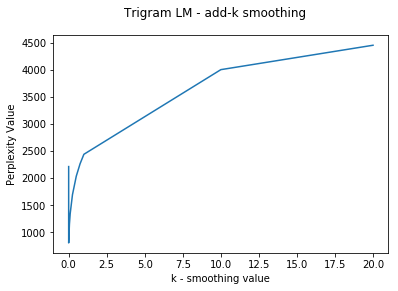

In [33]:
fig = plt.figure()
plt.plot(K, perplexity_var)
fig.suptitle('Trigram LM - add-k smoothing', fontsize=12)
plt.ylabel('Perplexity Value', fontsize=10)
plt.xlabel('k - smoothing value', fontsize=10)
fig.savefig('add_k.jpg')

In [36]:
add_k_smoothing(vocab_size, bigrams, trigrams, 0.001, test_new)

799.0265292389704

In [37]:
def linear_interpolation(lm, data, lambdas):
    log_perplexity = 0.0
    M = 0
    for sent in data:
        M += len(sent)
        sent_log_prob = 0.0
        for i in range(len(sent)-2):
            prob = 0.0
            prob += (lambdas[0] * lm.calc_unigram_prob(sent[i+2]))
            if (sent[i+1], sent[i+2]) in lm.bigrams.keys():
                prob += (lambdas[1] * lm.calc_bigram_prob(sent[i+1], sent[i+2]))
            if (sent[i], sent[i+1], sent[i+2]) in lm.trigrams.keys():
                prob += (lambdas[2] * lm.calc_trigram_prob(sent[i], sent[i+1], sent[i+2]))
            sent_log_prob += math.log(prob, 2)
        log_perplexity += sent_log_prob
    l = log_perplexity / M
    return math.pow(2, -1*l)

In [56]:
lambda_list = []
lambda_list.append([0.8, 0.1, 0.1])
lambda_list.append([0.7, 0.1, 0.2])
lambda_list.append([0.6, 0.1, 0.3])
lambda_list.append([0.5, 0.2, 0.3])
lambda_list.append([0.5, 0.25, 0.25])
lambda_list.append([0.5, 0.2, 0.3])
lambda_list.append([0.45, 0.25, 0.3])
lambda_list.append([0.4, 0.3, 0.3])
lambda_list.append([0.3, 0.35, 0.35])
lambda_list.append([0.3, 0.3, 0.4])
lambda_list.append([0.2, 0.35, 0.45])
lambda_list.append([0.15, 0.35, 0.5])
lambda_list.append([0.1, 0.3, 0.6])
lambda_list.append([0.1, 0.2, 0.7])
lambda_list.append([0.05, 0.15, 0.8])
lambda_list.append([0.05, 0.10, 0.85])
lambda_list.append([0.05, 0.05, 0.9])

lm = trigram_LM(train_new)
for lamdas in lambda_list:
    perx = linear_interpolation(lm, dev_new, lamdas)
    perx_train = linear_interpolation(lm, train_new, lamdas)
    print ('at x1 = {:f}, x2 = {:f}, x3 = {:f}, Trigram LM perplexity: Training = {:f}, Dev ={:f}'.format(lamdas[2], lamdas[1], lamdas[0], perx_train, perx))

at x1 = 0.100000, x2 = 0.100000, x3 = 0.800000, Trigram LM perplexity: Training = 33.197002, Dev =179.911308
at x1 = 0.200000, x2 = 0.100000, x3 = 0.700000, Trigram LM perplexity: Training = 21.794936, Dev =168.265189
at x1 = 0.300000, x2 = 0.100000, x3 = 0.600000, Trigram LM perplexity: Training = 16.591781, Dev =163.989104
at x1 = 0.300000, x2 = 0.200000, x3 = 0.500000, Trigram LM perplexity: Training = 15.715659, Dev =148.273939
at x1 = 0.250000, x2 = 0.250000, x3 = 0.500000, Trigram LM perplexity: Training = 17.211762, Dev =143.690876
at x1 = 0.300000, x2 = 0.200000, x3 = 0.500000, Trigram LM perplexity: Training = 15.715659, Dev =148.273939
at x1 = 0.300000, x2 = 0.250000, x3 = 0.450000, Trigram LM perplexity: Training = 15.333706, Dev =143.437207
at x1 = 0.300000, x2 = 0.300000, x3 = 0.400000, Trigram LM perplexity: Training = 14.981830, Dev =139.924257
at x1 = 0.350000, x2 = 0.350000, x3 = 0.300000, Trigram LM perplexity: Training = 13.301870, Dev =139.284559
at x1 = 0.400000, x

In [57]:
linear_interpolation(lm, test_new, [0.3, 0.35, 0.35])

140.61972894143184